In [48]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

filename = "Rhone_data_continuous.h5"
f = h5py.File(filename, 'r')
print("Keys: %s" % f.keys())


Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>


In [133]:
# LSTM / training parameters

split_fraction = 0.715
step = 2 # Sample rate (i.e., keep one in every six values)
look_back = 720 # How far to look back in time
learning_rate = 0.001
batch_size = 256
epochs = 10
sequence_length = int(look_back / step)
train_split = int(split_fraction * int(len(f['Discharge'])))

In [134]:
# dataset_all = keras.preprocessing.timeseries_dataset_from_array(
#     f['DAS Data'],
#     f['Discharge'],
#     sequence_length=sequence_length,
#     sampling_rate=step,
#     batch_size=batch_size
# )

x = np.transpose([chan[750] for chan in f['DAS Data']])
y = f['Discharge']

# Normalize by hand because LSTM normalization layers are complicated!

x_mean = np.mean( x[:train_split], axis=0 )
x_std  = np.std(  x[:train_split], axis=0 )

y_mean = np.mean( y[:train_split] )
y_std  = np.std(  y[:train_split] )

x_train = (x[0:train_split-1,] - x_mean)/x_std
#x_train = (x[0:train_split-1,:] - x_mean)/x_std
y_train = (y[0:train_split-1] - y_mean)/y_std

x_val = (x[train_split:] - x_mean)/x_std
y_val = (y[train_split:] - y_mean)/y_std

x_train = x_train.reshape(len(x_train), 1)
x_val  = x_val.reshape(len(x_val), 1)
y_train = y_train.reshape(len(y_train), 1)
y_val = y_val.reshape(len(y_val), 1)

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size
)

In [135]:
# def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
#     assert (train_split + test_split + val_split) == 1
# #https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438    
#     if shuffle:
#         # Specify seed to always have the same split distribution between runs
#         ds = ds.shuffle(shuffle_size, seed=12)
    
#     train_size = int(train_split * ds_size)
#     val_size = int(val_split * ds_size)
    
#     train_ds = ds.take(train_size)    
#     val_ds = ds.skip(train_size).take(val_size)
#     test_ds = ds.skip(train_size).skip(val_size)
    
#     return train_ds, val_ds, test_ds

In [136]:
# dataset_train, dataset_val, dataset_test = get_dataset_partitions_tf(dataset_all, len(f))

In [137]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 360, 1)
Target shape: (256, 1)


In [138]:
model = keras.Sequential([
    layers.LSTM(32),
    layers.Dense(1)
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

In [139]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
173/173 [==============================] - 37s 209ms/step - loss: 0.9526 - val_loss: 4.0687

Epoch 00001: loss improved from inf to 0.95262, saving model to model_checkpoint.h5
Epoch 2/10
173/173 [==============================] - 36s 207ms/step - loss: 0.9515 - val_loss: 4.2017

Epoch 00002: loss improved from 0.95262 to 0.95154, saving model to model_checkpoint.h5
Epoch 3/10
173/173 [==============================] - 35s 201ms/step - loss: 0.9376 - val_loss: 4.2118

Epoch 00003: loss improved from 0.95154 to 0.93760, saving model to model_checkpoint.h5
Epoch 4/10
173/173 [==============================] - 33s 191ms/step - loss: 0.9317 - val_loss: 4.2315

Epoch 00004: loss improved from 0.93760 to 0.93173, saving model to model_checkpoint.h5
Epoch 5/10
173/173 [==============================] - 33s 188ms/step - loss: 0.9276 - val_loss: 4.2339

Epoch 00005: loss improved from 0.93173 to 0.92760, saving model to model_checkpoint.h5
Epoch 6/10
173/173 [========================

Text(0, 0.5, 'Model Discharge')

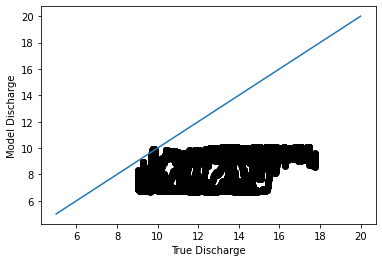

In [146]:
plt.subplots()
for xx, yy in dataset_val.take(len(dataset_val)):
    plt.plot(yy*y_std+y_mean,model.predict(xx)*y_std+y_mean,'ok')
plt.plot((5,20),(5,20))
plt.xlabel('True Discharge')
plt.ylabel('Model Discharge')